In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt


import numpy

In [2]:
BATCH_SIZE=64

## Vibe coded

#Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy array to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
])

# Download and load the training set
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [32]:
# 10 Epochs of training with Adam(lr=1e-3) and CrossEntropyLoss achieves 97.5% accuracy

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.Conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.Conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.Conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.FC = nn.Linear(64, 10)
        
        self.ReLU = nn.ReLU()
        self.MaxPool = nn.MaxPool2d(kernel_size=2)
        self.GlobalAvgPool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x: torch.Tensor):
        x = self.Conv1(x)
        x = self.ReLU(x)

        x = self.Conv2(x)
        x = self.ReLU(x)
        
        x = self.MaxPool(x)

        x = self.Conv3(x)
        x = self.ReLU(x)
        x = self.GlobalAvgPool(x)

        x = self.FC(x.reshape(-1, 64))
        # Note: CrossEntropyLoss applies softmax by itself
        return x

net = CNN()

In [42]:
EPOCHS = 3

lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
accuracies = []

for epoch in range(EPOCHS):
    t = tqdm(train_loader)
    for batch, y_true in t:
        y_pred = net(batch)
        loss = lossf(y_pred, y_true)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        accuracy = (y_pred.argmax(dim=1) == y_true).float().mean().item()

        t.set_description(f'loss: {loss.item():.3f} accuracy: {accuracy:.2%}')
        losses.append(loss.item())
        accuracies.append(accuracy)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

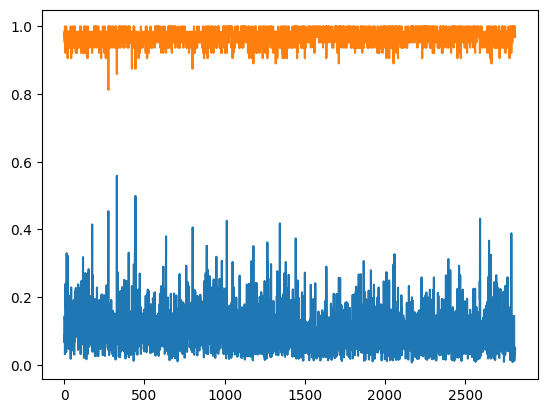

In [43]:
plt.plot(losses)
plt.plot(accuracies)
plt.show()

In [44]:
with torch.no_grad():
    accs = []
    for batch, label in tqdm(test_loader):
        y_pred = net(batch)
        accuracy = (y_pred.argmax(dim=1) == label).float().mean().item()
        accs.append(accuracy)

torch.tensor(accs).mean()

  0%|          | 0/157 [00:00<?, ?it/s]

tensor(0.9750)

In [40]:
torch.tensor(accs).mean()

tensor(0.9636)

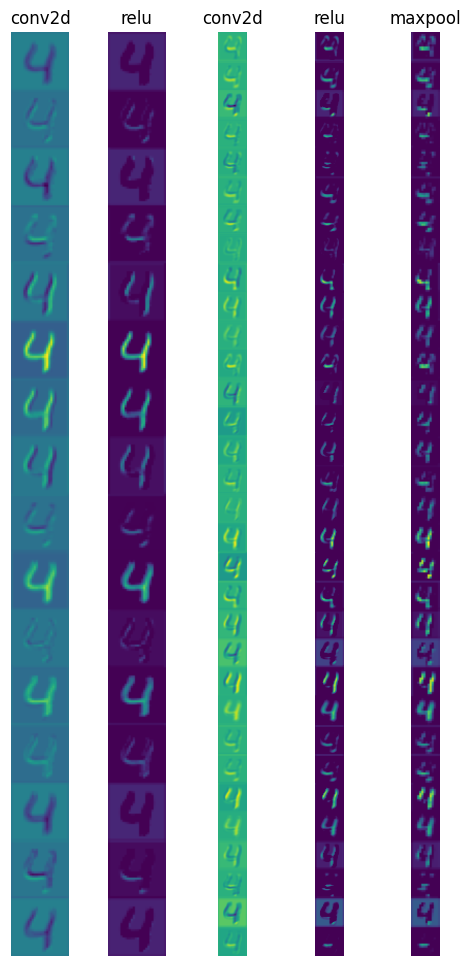

In [48]:
%matplotlib inline
images, _ = next(iter(test_loader))
image = images[4]
net(image).argmax()

c = net.Conv1(image).detach()
r = net.ReLU(c)

c2 = net.Conv2(r).detach()
r2 = net.ReLU(c2)
p2 = net.MaxPool(r2)

# Remove channel dimension and convert to numpy
img1 = c.reshape(-1, 28).numpy()
img2 = r.reshape(-1, 28).numpy()
img4 = c2.reshape(-1, 28).numpy()
img5 = r2.reshape(-1, 28).numpy()
img6 = p2.reshape(-1, 14).numpy()

# Create figure
plt.figure(figsize=(6, 12))  # width x height in inches

# Left image
plt.subplot(1, 5, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('conv2d')

# Right image
plt.subplot(1, 5, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('relu')

plt.subplot(1, 5, 3)
plt.imshow(img4)
plt.axis('off')
plt.title('conv2d')

# Right image
plt.subplot(1, 5, 4)
plt.imshow(img5)
plt.axis('off')
plt.title('relu')

plt.subplot(1, 5, 5)
plt.imshow(img6)
plt.axis('off')
plt.title('maxpool')

plt.show()

In [41]:
with torch.no_grad():
    accuracy = []
    for batch, label in tqdm(test_loader):
        y_pred = net(batch)
        accuracy.append((y_pred.argmax(dim=1) == label).float().mean().item())

sum(accuracy)/len(accuracy)

  0%|          | 0/157 [00:00<?, ?it/s]

0.9635748407643312